In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os

import rasterio

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [8]:
df = pd.read_csv("data/Pollutant Data/Final Asansol Data.csv", index_col="Timestamp")

# Preprocessing

In [9]:
df_train = df.loc[:'2023-12-31', ]
df_val = df.loc['2024-01-01':, ]

Split dataset into train-validation  
Train Set: 2018 to 2023  
Validation Set: 2024  
Test Set: 2025

In [10]:
scaler = MinMaxScaler()

train_sc = scaler.fit_transform(df_train)
val_sc = scaler.transform(df_val)

train_scaled = pd.DataFrame(train_sc, columns=scaler.get_feature_names_out(), index = df_train.index)
val_scaled = pd.DataFrame(val_sc, columns=scaler.get_feature_names_out(), index = df_val.index)

In [11]:
def create_sequences(data, input_len=24, output_len=1):
    X, y = [], []
    for i in range(len(data) - input_len - output_len):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len])
    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)

X_train, y_train = create_sequences(train_scaled.values, input_len=24, output_len=1)
X_val, y_val = create_sequences(val_scaled.values, input_len=24, output_len=1)

In [12]:
class AirQualityDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y.squeeze(1)  # make shape [batch, output_dim]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = AirQualityDataset(X_train, y_train)
val_dataset = AirQualityDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

LSTM requires features in same scale

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55882 entries, 2018-02-01 10:00:00 to 2024-12-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   55882 non-null  float64
 1   PM10    55882 non-null  float64
 2   NOx     55882 non-null  float64
 3   SO2     55882 non-null  float64
dtypes: float64(4)
memory usage: 4.1+ MB


# Modeling

### 1. LSTM

In [14]:
class LSTMModel(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, num_layers=num_layers, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [15]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
        model.train()
        total_loss = 0

        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss = loss.item()

        return total_loss / len(dataloader)
    
    
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(input_size=4, output_size=4, hidden_size=64, num_layers=2).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss = evaluate(model, val_loader, loss_fn, device)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 1/20 | Train Loss: 0.0000 | Val Loss: 0.0005
Epoch 2/20 | Train Loss: 0.0000 | Val Loss: 0.0005
Epoch 3/20 | Train Loss: 0.0000 | Val Loss: 0.0004
Epoch 4/20 | Train Loss: 0.0000 | Val Loss: 0.0004
Epoch 5/20 | Train Loss: 0.0000 | Val Loss: 0.0004
Epoch 6/20 | Train Loss: 0.0000 | Val Loss: 0.0004
Epoch 7/20 | Train Loss: 0.0000 | Val Loss: 0.0004
Epoch 8/20 | Train Loss: 0.0000 | Val Loss: 0.0004
Epoch 9/20 | Train Loss: 0.0000 | Val Loss: 0.0004
Epoch 10/20 | Train Loss: 0.0000 | Val Loss: 0.0004
Epoch 11/20 | Train Loss: 0.0000 | Val Loss: 0.0004
Epoch 12/20 | Train Loss: 0.0000 | Val Loss: 0.0004
Epoch 13/20 | Train Loss: 0.0000 | Val Loss: 0.0003
Epoch 14/20 | Train Loss: 0.0000 | Val Loss: 0.0003
Epoch 15/20 | Train Loss: 0.0000 | Val Loss: 0.0004
Epoch 16/20 | Train Loss: 0.0000 | Val Loss: 0.0003
Epoch 17/20 | Train Loss: 0.0000 | Val Loss: 0.0004
Epoch 18/20 | Train Loss: 0.0000 | Val Loss: 0.0004
Epoch 19/20 | Train Loss: 0.0000 | Val Loss: 0.0003
Epoch 20/20 | Train L

In [17]:
# Forward pass
X_val_tensor = X_val.to(device)
y_pred = model(X_val_tensor).cpu().detach().numpy()  # shape: [N, 4]
y_true = y_val.cpu().numpy()  # shape: [N, 4] or maybe [N, 1, 4]

# Squeeze if necessary
if y_true.ndim == 3:
    y_true = y_true.squeeze(1)  # shape: [N, 4]

# Inverse scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_true_inv = scaler.inverse_transform(y_true)

In [18]:
print("y_pred shape:", y_pred.shape)
print("y_true shape:", y_true.shape)

df_val.shape

y_pred shape: (8755, 4)
y_true shape: (8755, 4)


(8780, 4)

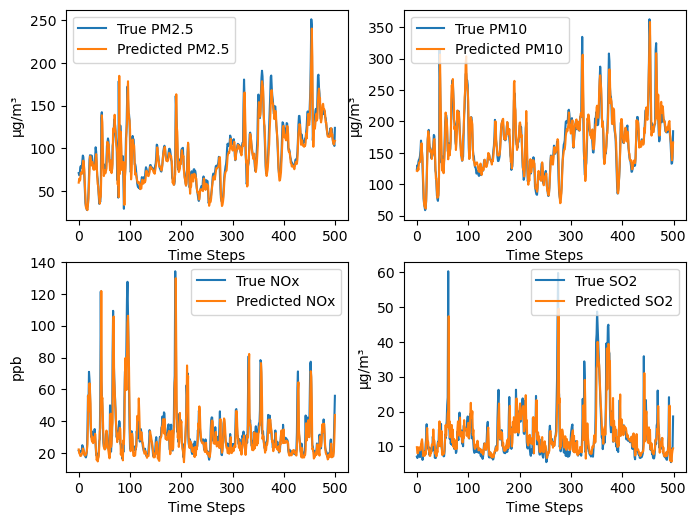

In [19]:
fig, ax = plt.subplots(2,2, figsize=(8, 6))
ax = ax.flatten()
labels = ["PM2.5", "PM10", "NOx", "SO2"]

for i in range(0,4):
    
    ax[i].plot(y_true_inv[:500, i], label=("True "+labels[i]))
    ax[i].plot(y_pred_inv[:500, i], label=("Predicted "+labels[i]))
    
    ax[i].set_xlabel("Time Steps")
    
    if(i!=2):
        ax[i].set_ylabel("µg/m³")
    else:
        ax[i].set_ylabel("ppb")
    
    ax[i].legend()
    
plt.show()

In [20]:
mae1 = mean_absolute_error(y_true_inv[:, 0], y_pred_inv[:, 0])
print("MAE on PM2.5 (µg/m³):", mae1)

mae2 = mean_absolute_error(y_true_inv[:, 1], y_pred_inv[:, 1])
print("MAE on PM10 (µg/m³):", mae2)

mae3 = mean_absolute_error(y_true_inv[:, 2], y_pred_inv[:, 2])
print("MAE on NOx ppb:", mae3)

mae4 = mean_absolute_error(y_true_inv[:, 3], y_pred_inv[:, 3])
print("MAE on SO2 (µg/m³):", mae4)

MAE on PM2.5 (µg/m³): 6.7361197
MAE on PM10 (µg/m³): 9.800627
MAE on NOx ppb: 3.8842723
MAE on SO2 (µg/m³): 1.6271108


In [21]:
mse1 = mean_squared_error(y_true_inv[:, 0], y_pred_inv[:, 0])
print("MSE on PM2.5 (µg/m³):", mse1)

mse2 = mean_squared_error(y_true_inv[:, 1], y_pred_inv[:, 1])
print("MSE on PM10 (µg/m³):", mse2)

mse3 = mean_squared_error(y_true_inv[:, 2], y_pred_inv[:, 2])
print("MSE on NOx ppb:", mse3)

mse4 = mean_squared_error(y_true_inv[:, 3], y_pred_inv[:, 3])
print("MSE on SO2 (µg/m³):", mse4)

MSE on PM2.5 (µg/m³): 120.291046
MSE on PM10 (µg/m³): 269.983
MSE on NOx ppb: 124.83127
MSE on SO2 (µg/m³): 8.955808


In [22]:
rmse1 = root_mean_squared_error(y_true_inv[:, 0], y_pred_inv[:, 0])
print("RMSE on PM2.5 (µg/m³):", rmse1)

rmse2 = root_mean_squared_error(y_true_inv[:, 1], y_pred_inv[:, 1])
print("RMSE on PM10 (µg/m³):", rmse2)

rmse3 = root_mean_squared_error(y_true_inv[:, 2], y_pred_inv[:, 2])
print("RMSE on NOx ppb:", rmse3)

rmse4 = root_mean_squared_error(y_true_inv[:, 3], y_pred_inv[:, 3])
print("RMSE on SO2 (µg/m³):", rmse4)

RMSE on PM2.5 (µg/m³): 10.967728
RMSE on PM10 (µg/m³): 16.43116
RMSE on NOx ppb: 11.1727915
RMSE on SO2 (µg/m³): 2.9926255


### 2. CNN

In [11]:
folder = "data/Asansol AOD"

for filename in sorted(os.listdir(folder)):
    if filename.endswith(".tif"):
        
        path = os.path.join(folder, filename)
        with rasterio.open(path) as src:
            arr = src.read(1)